# Experiment
I set the loss function = mu and see how mu is updated in pyro and pytorch. 
Obvously dL/dmu = 1 and therefore mu is linearly decreasing in time in an identical way in pyro and pytorch.
Next I specify mu as a pyro parameters constrained to be positive or unit_interval. The update rule in pyro becomes drastically different.  

### TORCH

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

mu = torch.tensor(1.0, requires_grad=True)
optimizer = optim.SGD([mu], lr=1E-2)
history_torch = [] 
for n in range(100):
    optimizer.zero_grad()   # zero the gradient buffers
    loss = mu
    loss.backward()
    optimizer.step()  
    history_torch.append(mu.item())

### PYRO

In [2]:
import pyro
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import SVI, Trace_ELBO
import numpy as np

import torch
from pyro.distributions.torch_distribution import TorchDistribution
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all
from numbers import Number


class CustomLogProbTerm(TorchDistribution):
    """ This is a bogus distribution which only has the log_prob method.
        It always return custom_log_prob for any value.
        See:
        def log_prob(self, value):
            return self.custom_log_prob
    """
    arg_constraints = {'custom_log_prob': constraints.real}

    def __init__(self, custom_log_prob=None, validate_args=None):
        if custom_log_prob is None:
            raise ValueError("custom_log_prob must be specified")
        else:
            self.custom_log_prob = custom_log_prob

        if isinstance(self.custom_log_prob, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.custom_log_prob.size()
        super(CustomLogProbTerm, self).__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CustomLogProbTerm, _instance)
        batch_shape = torch.Size(batch_shape)
        new.custom_log_prob = self.custom_log_prob.expand(batch_shape)
        super(CustomLogProbTerm, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def log_prob(self, value):
        return self.custom_log_prob
    
def model1():
    one = torch.ones([1])
    mu = pyro.param("mu", one)
    pyro.sample("LOSS", CustomLogProbTerm(custom_log_prob=-mu), obs=-mu)

def model2():
    one = torch.ones([1])
    mu = pyro.param("mu", one, constraint=constraints.positive)
    pyro.sample("LOSS", CustomLogProbTerm(custom_log_prob=-mu), obs=-mu)

def model3():
    one = torch.ones([1])
    mu = pyro.param("mu", one, constraint=constraints.unit_interval)
    pyro.sample("LOSS", CustomLogProbTerm(custom_log_prob=-mu), obs=-mu)

def guide():
    pass


pyro.clear_param_store()
pyro.set_rng_seed(0)
optimizer = SGD({"lr": 1.0e-2})
svi = SVI(model1, guide, optimizer, loss=Trace_ELBO())
history_pyro1 = []

for n in range(100):
    loss = svi.step()
    mu = pyro.param("mu").item()
    history_pyro1.append(mu)    
    
pyro.clear_param_store()
pyro.set_rng_seed(0)
optimizer = SGD({"lr": 1.0e-2})
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())
history_pyro2 = []

for n in range(100):
    loss = svi.step()
    mu = pyro.param("mu").item()
    history_pyro2.append(mu) 
    
pyro.clear_param_store()
pyro.set_rng_seed(0)
optimizer = SGD({"lr": 1.0e-2})
svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())
history_pyro3 = []

for n in range(100):
    loss = svi.step()
    mu = pyro.param("mu").item()
    history_pyro3.append(mu) 
    

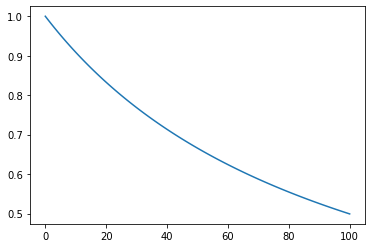

In [3]:
tmp = [1]
for n in range(100):
    x = tmp[-1]
    tmp.append(x*np.exp(-1E-2*x))
plt.plot(tmp)

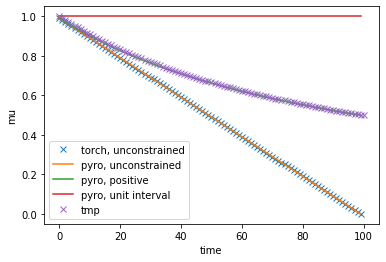

In [4]:
plt.plot(history_torch,'x',label='torch, unconstrained')
plt.plot(history_pyro1,'-',label='pyro, unconstrained')
plt.plot(history_pyro2,'-',label='pyro, positive')
plt.plot(history_pyro3,'-',label='pyro, unit interval')
plt.plot(tmp,'x',label='tmp')

#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.xlabel('time')
plt.ylabel('mu')
plt.show()

# TEST HOW TO IMPLEMENT GECO
Minimize f(x) subject to the constraint C(x)>0

In [63]:
def f(x):
    """ Function to minimize"""
    return torch.abs(x-5) + (x-5).pow(2)

def C(x):
    """ Constraint needs to be satistfied in the form C(x)>0"""
    #return 0*x
    return (x-7)
    #return (x-2)


pyro.clear_param_store()
pyro.set_rng_seed(0)
batch_size=80
alpha = 0.0

class VAEtest(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Instantiate all the modules
        self.fx = None
        self.Cx = None
        self.mu = None
        self.MA_Cx = None
        
        # Put everything on the cude if necessary
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.cuda()
            
    def model(self):
    
        one = torch.ones([1])
        x = pyro.param("x", torch.rand(batch_size))
        #mu = 0*one
        mu = pyro.param("mu", one, constraint=constraints.interval(0.1, 10))
        #mu = pyro.param("mu", one, constraint=constraints.positive)
        
        with pyro.plate("batch", batch_size):
            
            fx = f(x)
            Cx = C(x)
            with torch.no_grad():
                Cx_mean = torch.mean(Cx)
                if self.MA_Cx is None:
                    self.MA_Cx = Cx_mean
                self.MA_Cx = alpha * self.MA_Cx + (1.0-alpha) * Cx_mean
                desired_grad_mu = - self.MA_Cx
            objective = - fx + mu * (Cx - Cx.detach() + desired_grad_mu)
            
            self.fx = torch.mean(fx).detach().item()
            self.Cx = torch.mean(Cx).detach().item()
            self.mu = mu.detach().item()
            self.mean_x = torch.mean(x).detach().item()
            self.x = x.detach().numpy().reshape(-1,1)
            
            pyro.sample("LOSS", CustomLogProbTerm(custom_log_prob=objective), obs=objective)
        
    def guide(self):
        pass


pyro.clear_param_store()
pyro.set_rng_seed(0)
optimizer = SGD({"lr": 5.0e-3})
vae = VAEtest()
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
history = {'fx' : [],
           'Cx' : [],
           'mu' : [],
           'mean_x' : [],
            'x' : None}


for n in range(10000):
    loss = svi.step()
    history['mu'].append(vae.mu)    
    history['fx'].append(vae.fx)    
    history['Cx'].append(vae.Cx) 
    history['mean_x'].append(vae.mean_x) 
    if history['x'] is None:
        history['x'] = vae.x
    else:
        history['x'] = np.concatenate((history['x'], vae.x), axis=1)
        
print(n)

9999


In [64]:
str(optimizer.pt_optim_args['lr'])

'0.005'

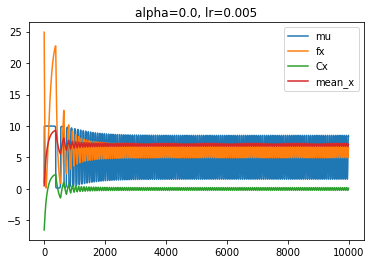

In [65]:
plt.plot(history['mu'],label='mu')
plt.plot(history['fx'],label='fx')
plt.plot(history['Cx'],label='Cx')
plt.plot(history['mean_x'],label='mean_x')
plt.legend()
plt.title("alpha="+str(alpha)+", lr="+str(optimizer.pt_optim_args['lr']))
plt.savefig("history_alpha="+str(alpha)+".png")

In [58]:
print("mu",history['mu'][-5:])
print("fx",history['fx'][-5:])
print("Cx",history['Cx'][-5:])
print("mean_x",history['mean_x'][-5:])

mu [9.990360260009766, 9.99035930633545, 9.99035930633545, 9.990358352661133, 9.9903564453125]
fx [14.500521659851074, 14.502288818359375, 14.504060745239258, 14.505830764770508, 14.507601737976074]
Cx [1.3388606309890747, 1.3390917778015137, 1.3393231630325317, 1.3395541906356812, 1.3397856950759888]
mean_x [8.338861465454102, 8.339092254638672, 8.339323997497559, 8.339554786682129, 8.3397855758667]


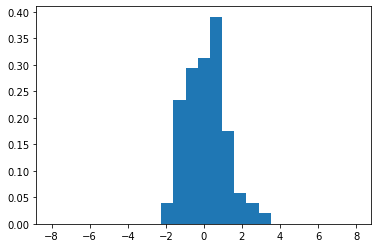

In [49]:
_ = plt.hist(history['x'][:,0], density=True, bins=25, range=[-8,8])

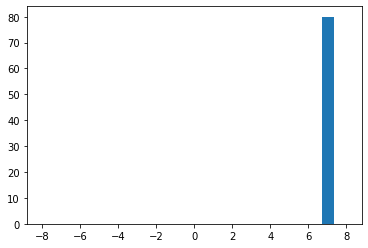

In [39]:
_ = plt.hist(history['x'][:,-1], density=False, bins=25, range=[-8,8])